#Second Practical work

This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





## Gracia Estrán Buyo 
NIA :100452014
## Marta Almagro Fuello 
NIA: 100451979

##Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [ ]:
#!pip install pycuda

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [ ]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time

In [ ]:
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

Populating the interactive namespace from numpy and matplotlib


##Mount Google Drive and access grant
We use Google API to allow access to our Google Drive.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [ ]:
from os.path import join
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MYDRIVE = "/content/drive/My Drive/"

**List Files in Folders**

In [ ]:
!ls /content/drive/My\ Drive/

 chess.jpg	   'Colab Notebooks'   fence.jpg
 cloudsonjupi.jpg   digits.jpg	       hand-x-ray.jpg


We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [ ]:
IMAGE = join(MYDRIVE, 'cloudsonjupi.jpg')
IMAGE1 = join(MYDRIVE, 'chess.jpg')

In [ ]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/My Drive/cloudsonjupi.jpg


Loads an image in a numpy variable, and show.

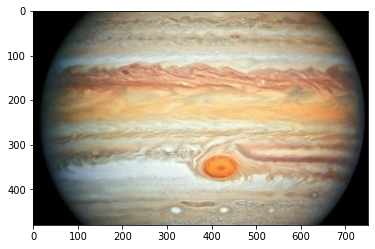

In [ ]:
image = np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

#FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [ ]:
kernel_source = """
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              ) 
{ 
    // Here, we define the memory space on-chip for our shared information and define the size of the image block
    float __shared__ image_block[%(BLOCK_SIZE)s+%(FILTER_ROWS)s-1][%(BLOCK_SIZE)s+%(FILTER_COLS)s-1];
    
    // Calculate the halo
    int padsize_x = NumColsFilter/2;
    int padsize_y = NumRowsFilter/2;
    
    // Shift to obtain input indices, which are outside the output frame
    int tx = threadIdx.x + padsize_x;
    int ty = threadIdx.y + padsize_y;
    
    // Get the output indices (Row * Width + Col or Column * Height + Row)
    int idxY = blockIdx.y * blockDim.y + threadIdx.y; 
    int idxX = blockIdx.x * blockDim.x + threadIdx.x;

    // Then you have to construct the memory position using the indexes formula:
    // Row * Width + Col 
    int px = idxY * NumColsImg + idxX;

    // 
    image_block[ty][tx] = image[px];

    __syncthreads(); // Synchronize to make sure the matrices are loaded

    // Padding the tiles
    // Firstly let's check the edges

    //Left edge
    if (threadIdx.x==0 && padsize_x>0){
        if (idxX == 0){
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i] = image[px];
            }
        }
        else{
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i] = image[px-i]; //Left padding
          }
        }
      }
    //Right edge
    else if (threadIdx.x==%(BLOCK_SIZE)s-1 && padsize_x>0){
      if (idxX == NumColsImg-1){
        for (int i = 1; i<=padsize_x; i++){
          image_block[ty][tx+i] = image[px];
          }
      }
      else{
        for (int i = 1; i<=padsize_x; i++){
          image_block[ty][tx+i] = image[px+i]; //Right padding
        }
      }
    }
    //Superior edge
    else if (threadIdx.y==0 && padsize_y>0){
      if (idxY == 0){
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty-i][tx] = image[px];
          }
      }
      else{
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty-i][tx] = image[(idxY-i)*NumColsImg + idxX]; //Superior padding
        }
      }
    }
    //Inferior edge
    else if (threadIdx.y==%(BLOCK_SIZE)s-1 && padsize_y>0){
      if (idxY == NumRowsImg-1){
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty+i][tx] = image[px];
          }
      }
      else{
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty+i][tx] = image[(idxY+i)*NumColsImg + idxX]; //Inferior padding
        }
      }
    }
  
    
    // Second let's check the corners:

    //Inferior right corner
    else if (threadIdx.y==%(BLOCK_SIZE)s-1 && threadIdx.x==%(BLOCK_SIZE)s-1 && padsize_y>0 && padsize_x>0){
    
      //Middle of the image => Padding in both directions
      if (idxX != NumColsImg-1 && idxY != NumRowsImg-1){ // If the indexes are not the last row or column
        for (int i = 1; i<=padsize_x; i++){
          for (int j = 1; j<=padsize_y; j++){
            image_block[ty+j][tx+i] = image[(idxY+j)* NumColsImg + (idxX+i)]; //Corner padding = Right padding + Inferior padding
          }
          image_block[ty][tx+i] = image[(idxY)*NumColsImg + (idxX+i)]; //Right padding
        }
          
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty+i][tx] = image[(idxY+i)*NumColsImg + idxX]; //Inferior padding
        }
      }
        
      //Corner or edge of the image
      else{ 
        for (int i = 1; i<=padsize_x; i++){
          for (int j = 1; j<=padsize_y; j++){
            image_block[ty+j][tx+i]=image[px];
          }
        }
        //Is not the right edge => we have to do padding
        if (idxX != NumColsImg-1){ 
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx+i]=image[(idxY)*NumColsImg + (idxX+i)]; //Right padding
          }
        }
        //Is the right edge
        else{ 
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx+i] = image[px];
          }
        }
        //Is not the inferior edge => we have to do padding
        if (idxY != NumRowsImg-1){ 
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty+i][tx] = image[(idxY+i)*NumColsImg + idxX]; // Inferior padding
          }
        }
        //Is the inferior edge
        else{
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty+i][tx] = image[px];
          }
        }
      }
    }
    
    //Superior right corner
    else if (threadIdx.x==%(BLOCK_SIZE)s-1 && padsize_x>0 && threadIdx.y==0 && padsize_y>0){ 

      // Middle of the image => Padding in both directions
      if (idxX != NumColsImg-1 && idxY != 0){ //si no estamos en esquina de imagen     
        for (int i = 1; i<=padsize_x; i++){
          for (int j = 1; j<=padsize_y; j++){
            image_block[ty-j][tx+i] = image[(idxY-j)*NumColsImg + (idxX+i)]; //Corner padding = Right padding + Superior padding
          }
          image_block[ty][tx+i] = image[(idxY)*NumColsImg + (idxX+i)]; //Right padding
        }
            
        for (int i = 1; i<=padsize_y; i++){
          image_block[ty-i][tx] = image[(idxY-i)*NumColsImg + idxX]; //Superior padding
        }
      }
      // Edge or corner of the images
      else{ 
        for (int i = 1; i<=padsize_x; i++){
          for (int j = 1; j<=padsize_y; j++){
            image_block[ty-j][tx+i] = image[px];
          }
        }
        // Is not the rigth edge => Right padding
        if (idxX != NumColsImg-1){
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx+i] = image[(idxY)*NumColsImg + (idxX+i)]; //Right padding
          }
        }
        // Is the right edge 
        else{ //es arista der
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx+i] = image[px];
          }
        }
        // Is not the superior edge => Superior padding  
        if (idxY != 0){ //no es arista sup
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty-i][tx]=image[(idxY-i)*NumColsImg + idxX]; //Superior padding
          }
        }
        // Is the superior edge
        else{ 
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty-i][tx] = image[px]; 
          }
        }
      }
    }

    //Inferior left corner
    if (threadIdx.y==%(BLOCK_SIZE)s-1 && padsize_y>0 && threadIdx.x==0 && padsize_x>0){
      
      // Middle of the image => Padding in both directions
      if (idxX != 0 && idxY != NumRowsImg-1){   
          for (int i = 1; i<=padsize_x; i++){
            for (int j = 1; j<=padsize_y; j++){
              image_block[ty+j][tx-i] = image[(idxY+j)*NumColsImg + (idxX-i)]; //Corner padding = Left padding + Inferior padding
            }
            image_block[ty][tx-i] = image[(idxY)*NumColsImg + (idxX-i)]; //Left padding
          }
          
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty+i][tx] = image[(idxY+i)*NumColsImg + idxX]; //Inferior padding
          }
      }
      // Edge or corner of the image
      else{ 
        for (int i = 1; i<=padsize_x; i++){
          for (int j = 1; j<=padsize_y; j++){
            image_block[ty+j][tx-i] = image[px];
          }
        }
        // Is not the left edge => Left padding
        if (idxX != 0){ 
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i]=image[(idxY)*NumColsImg + (idxX-i)]; //Left padding
          }
        }
        // Is the left edge
        else{
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i]=image[px];
          }
        }
        // Is not inferior edge 
        if (idxY != NumRowsImg-1){ 
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty+i][tx]=image[(idxY+i)*NumColsImg + idxX]; //Inferior padding
          }
        }
        // Is the inferior edge
        else{ 
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty+i][tx]=image[px]; 
          }
        }
      }
    } 
   
    //Superior left corner
    if (threadIdx.y==0 && padsize_y>0 && threadIdx.x==0 && padsize_x>0){

      // Middle of the image => Padding in both directions
      if (idxX != 0 && idxY != 0){ //si no estamos en esquina de imagen          
          for (int i = 1; i+1<=padsize_x; i++){
            for (int j = 1; j+1<=padsize_y; j++){
              image_block[ty-j][tx-i] = image[(idxY-j)*NumColsImg + (idxX-i)]; //Corner padding = Left padding + Superior padding
            }
            image_block[ty][tx-i] = image[(idxY)*NumColsImg + (idxX-i)]; // Left padding
          }
          
          for (int i = 1; i+1<=padsize_y; i++){
            image_block[ty-i][tx] = image[(idxY-i)*NumColsImg + idxX]; //Superior padding
          }
      }
      // Edge or corner of the image
      else{ //arista o esquina de imagen
          for (int i = 1; i<=padsize_x; i++){
            for (int j = 1; j<=padsize_y; j++){
              image_block[ty-j][tx-i] = image[px];
            }
          }
        // Is not the left edge
        if (idxX != 0){ 
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i] = image[(idxY)*NumColsImg + (idxX-i)]; //Left padding
          }
        }
        // Is the left edge
        else{
          for (int i = 1; i<=padsize_x; i++){
            image_block[ty][tx-i] = image[px];
          }
        }
        // Is not the superior edge
        if (idxY != 0){ 
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty-i][tx] = image[(idxY-i)*NumColsImg + idxX]; //Superior padding
          }
        }
        // Is the superior edge
        else{
          for (int i = 1; i<=padsize_y; i++){
            image_block[ty-i][tx] = image[px]; 
          }
        }
      }
    }

    __syncthreads(); // Synchronize to make sure the matrices are loaded
    
    
    // Only compute if you are an output tile element
    if (idxY < NumRowsImg && idxX < NumColsImg){
      
      float output = 0.0f;  // Initialize the variable output
      
      for (int i = 0; i < NumRowsFilter; i++) { // Run through every row 
        for (int j = 0; j < NumColsFilter; j++) { // Run through every column
          // Multiply the mask cell by the image block cell
          output += filter_mask[i * NumColsFilter + j] * image_block[i + ty-padsize_y][j + tx-padsize_x];
          
      filtered_image[px] = output;  // Modifify the GPU array 

        }
      }     
    }
    __syncthreads(); // Synchronize to make sure the matrices are loaded

}

"""

Recover the image shape, and select the two first items (rows and columns).

In [ ]:
image_shape = image.shape[0:2]

Set block size and grid size.

In [ ]:
block_s = 16
block_size = (block_s,block_s,1)
grid_size = (int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)))

Allocates the target image memory.

In [ ]:
result_image = np.zeros(image.shape,dtype=np.uint8)

In [ ]:
depth = image.shape[2]

Here we defines our sample filter masks.

In [ ]:
filter1 = np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2 = np.array([[0.5, 0 , -0.5]])
filter3 = np.array([[0.5],[0],[-0.5]])

filter4 = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5 = np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

We select the filter mask, and upload to the GPU device.

In [ ]:
filter_mask = filter4.astype(np.float32)
filter_mask_gpu = gpuarray.to_gpu(filter_mask)


We get the filter size for the horizontal and the vertical axis in order to compute the kernel_code

In [ ]:
filter_rows = filter_mask.shape[0]
filter_columns = filter_mask.shape[1]

In [ ]:
kernel_source = kernel_source % {
    'BLOCK_SIZE' : block_s,
    'FILTER_ROWS' : np.int32(filter_rows),
    'FILTER_COLS' : np.int32(filter_columns)  
}

And now we can import the kernel definition to python

In [ ]:
kernel = SourceModule(kernel_source)
image_filter = kernel.get_function ('image_filter')

##Prepares the execution environment 

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [ ]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [ ]:
start_t = time.time()
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer = (image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu = gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer = filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store, 
                                                                  #casting the data type from double to uint8
end_t = time.time()

#Show results


In [ ]:
print("Execution time is: {0} seconds.".format(end_t - start_t))

Execution time is: 0.015688180923461914 seconds.


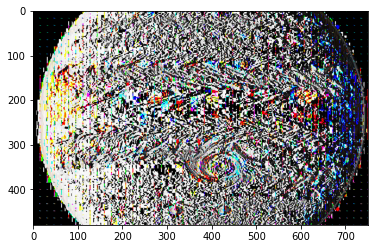

In [ ]:
plt.figure()
plt.imshow(result_image)

# Conclusions 

In this problem we are using the shared memory to store temporally the data. Each thread will have his assigned data in our shared memory.

In memory tiling we are going through every tile (which is loaded from the global memory) and it has the multiple threads to access it. We need to do padding that is why we have different cases depending on if we are in a corner or a edge.

As the threads can have a small time difference in excuted that is why the special command "__synchthreads()" is used, to coordinate and synchronize the thread.

To sum up, tile-based rendering is a technique used by the GPUs to reduce the bandwidth requirements of accessing on-chip memory and proceed efficiently.
